In [2]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
import pickle
import dask.dataframe as dd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import subprocess
import random
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
import scipy.stats as stats
from scipy.stats import pearsonr
import numpy as np
import cvxpy as cp

In [35]:
vcf_file = '/carnegie/nobackup/scratch/xwu/grenet/hapFIRE_updatedVCF/greneNet_final_v1.1_LDpruned.recode.vcf'
vcf = allel.read_vcf(vcf_file)

samples = vcf['samples']
samples = samples.astype(int)

In [79]:
first_gen_samples = pd.read_csv('../key_files/generation_1_sample_names.txt',header=None)[0]

In [80]:
founder_ecotype_frequency = pd.read_csv('../key_files/founder_ecotype_frequency.txt', sep = '\t',header=None)

founder_ef_series = founder_ecotype_frequency[1]
founder_ef_series.index = samples
merged_ecotype_frequency = pd.read_csv('../key_files/merged_ecotype_frequency.txt', sep = '\t',  usecols = first_gen_samples)
merged_ecotype_frequency.index = samples
my_p1_over_p0 = merged_ecotype_frequency.div(founder_ef_series, axis=0)
my_p1_over_p0.columns = pd.Series(my_p1_over_p0.columns).str.split('_').str[0] + '_' + pd.Series(my_p1_over_p0.columns).str.split('_').str[2]

real_ef = my_p1_over_p0.copy()

In [81]:
split_number = 2

In [82]:
genomic_offset_file = f'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/jacknife_first_gen/split_number_{split_number}/delta_p/results_genomic_offset.csv' 

In [83]:
with open('splits_samples_first_gen.pkl', 'rb') as file:
    splits_samples = pickle.load(file)

len(splits_samples) ## 100

31

In [84]:
for split_number in range(31):
    # get the train and split samples for this split
    train_samples = splits_samples[split_number][0]
    test_samples = splits_samples[split_number][1]
    
    genomic_offset_file = f'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/jacknife_first_gen/split_number_{split_number}/delta_p/results_genomic_offset.csv' 
    genomic_offset_results = f'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/jacknife_first_gen/split_number_{split_number}/delta_p/metrics_genomic_offset.csv' 

    go = pd.read_csv(genomic_offset_file).drop('Unnamed: 0',axis=1)
    
    ## convert the columns of the prediciton into just plot_site because the real values are in those terms 
    test_samples_mod = pd.Series(test_samples).str.split('_').str[0] + '_' + pd.Series(test_samples).str.split('_').str[2]
    go.columns = test_samples_mod
    
    ## bring the real values 
    real_ef_test = real_ef[test_samples_mod]
    
    print((go.columns == real_ef_test.columns).all())
    go.index = real_ef_test.index
    results_go = {}
    for i in real_ef_test.columns:
        both = pd.concat([real_ef_test[i], go[i]],axis=1)
        both.columns = ['real', 'pred'] 
    
        both = both.sort_values('pred')
    
        # Compute Spearman's rank correlation
        sp_correlation, _ = spearmanr( both['real'], both['pred'])        
        
        ## computer pearson corr
        X = both['real'].values # Independent variable
        y = both['pred'].values 
    
        pearsonr_value = pearsonr(X, y)[0]
        
        results_go[i] = [pearsonr_value, sp_correlation]
    
    results_go = pd.DataFrame(results_go).T
    results_go.columns = ['pearsonr', 'sp_correlation']
    results_go.to_csv(genomic_offset_results)
        
    print(f'done{split_number}')

True
done0
True
done1
True
done2
True
done3
True
done4
True
done5
True
done6
True
done7
True
done8
True
done9
True
done10
True
done11
True
done12
True
done13
True
done14
True
done15
True
done16
True
done17
True
done18
True
done19
True
done20
True
done21
True
done22
True
done23
True
done24
True
done25
True
done26
True
done27
True
done28
True
done29
True
done30


In [3]:
all_ef = pd.DataFrame()
for split_number in range(31):
    genomic_offset_results = f'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/jacknife_first_gen/split_number_{split_number}/delta_p/metrics_genomic_offset.csv' 
    genomic_offset_results = pd.read_csv(genomic_offset_results)
    genomic_offset_results['site'] = genomic_offset_results['Unnamed: 0'].str.split('_').str[0]
    all_ef = pd.concat([all_ef,genomic_offset_results])

In [4]:
all_ef

,Unnamed: 0,pearsonr,sp_correlation,site
0,1_1,0.224910,0.132153,1
1,1_2,-0.001344,-0.011955,1
2,1_3,-0.045136,-0.137835,1
3,1_4,-0.133861,-0.144738,1
4,1_5,0.030970,-0.089542,1
...,...,...,...,...
7,60_8,0.053755,0.200595,60
8,60_9,0.094256,0.203083,60
9,60_10,0.043567,0.115058,60
10,60_11,0.188980,0.139014,60


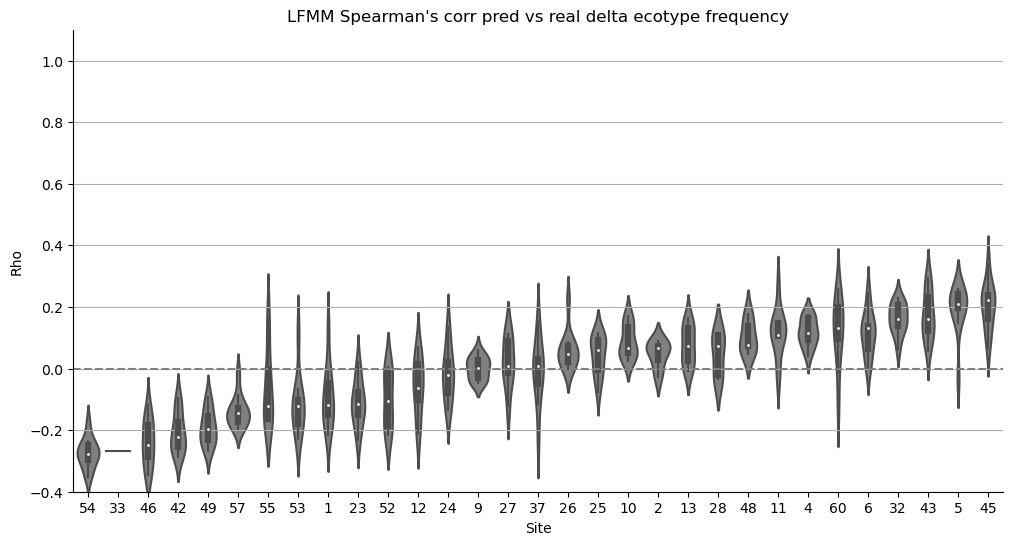

In [5]:
metric = 'sp_correlation'
#all_ef = all_ef.groupby(['sample','site'])['r2'].mean().reset_index()

medians = all_ef.groupby('site')[metric].median().sort_values()

# Set the size of the plot
plt.figure(figsize=(12, 6))  # You can adjust the width and height as needed

# Create the plot, ordering by median metric
# Use 'scale' to adjust the width of violins; options are 'area', 'count', or 'width'
sns.violinplot(data=all_ef, y=metric, x='site', order=medians.index, color = 'Grey')

# Draw a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--')  # Color and style are adjustable
plt.ylim(-0.4, 1.1)
plt.grid(axis='y')
# Remove top and right spines
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)  # Remove the top spine
ax.spines['right'].set_visible(False)

# Optionally, add labels or a title
plt.title('LFMM Spearman\'s corr pred vs real delta ecotype frequency')
plt.xlabel('Site')
plt.ylabel('Rho')
#plt.savefig('LFMM_sp.png')
# Show the plot
plt.show()

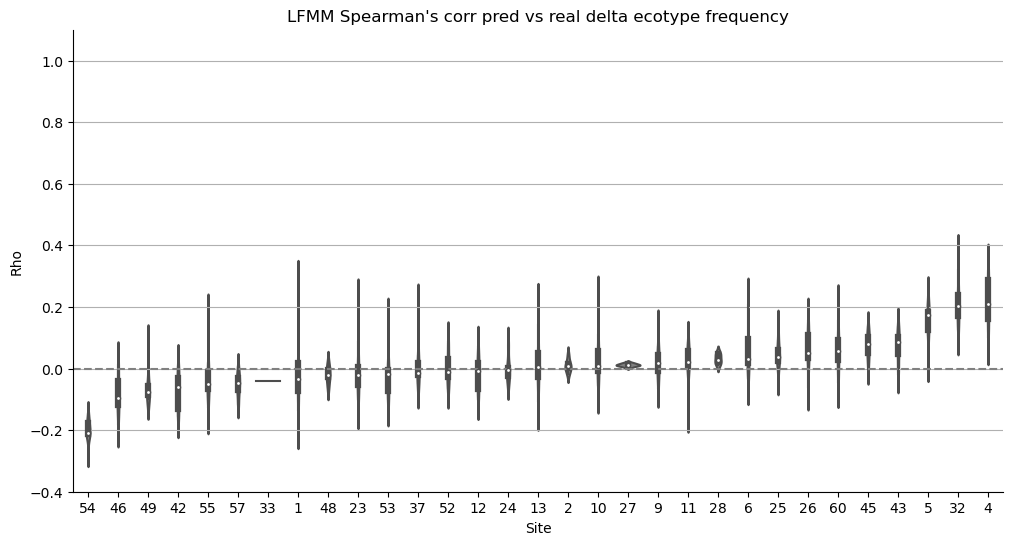

In [7]:
metric = 'pearsonr'
#all_ef = all_ef.groupby(['sample','site'])['r2'].mean().reset_index()

medians = all_ef.groupby('site')[metric].median().sort_values()

# Set the size of the plot
plt.figure(figsize=(12, 6))  # You can adjust the width and height as needed

# Create the plot, ordering by median metric
# Use 'scale' to adjust the width of violins; options are 'area', 'count', or 'width'
sns.violinplot(data=all_ef, y=metric, x='site', order=medians.index, color = 'Grey')

# Draw a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--')  # Color and style are adjustable
plt.ylim(-0.4, 1.1)
plt.grid(axis='y')
# Remove top and right spines
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)  # Remove the top spine
ax.spines['right'].set_visible(False)

# Optionally, add labels or a title
plt.title('LFMM Spearman\'s corr pred vs real delta ecotype frequency')
plt.xlabel('Site')
plt.ylabel('Rho')
plt.savefig('LFMM_go_pearson.png')
# Show the plot
plt.show()

In [ ]:
vcf_file = '/carnegie/nobackup/scratch/xwu/grenet/hapFIRE_updatedVCF/greneNet_final_v1.1_LDpruned.recode.vcf'
vcf = allel.read_vcf(vcf_file)

samples = vcf['samples']
samples = samples.astype(int)

In [5]:
## bring the founder 
af_founder = pd.read_csv('../leave_1_out/af_founder.csv')

In [6]:
#delta_p_file = 'delta_p.csv'
#delta_p = dd.read_csv(delta_p_file, sep = ',')

#delta_p = delta_p.compute() 

#delta_p = delta_p.reset_index(drop=True)

In [7]:
genotype_counts = pd.read_csv('../leave_1_out/genotype_counts_fullgenome231ecotypes.csv').drop('Unnamed: 0', axis=1)

In [8]:
final_ter = pd.read_csv('../final_gen.csv')['sample_name']

FileNotFoundError: [Errno 2] No such file or directory: '../final_gen.csv'

In [15]:
### DELTA ECOTYPE FREQ
#path_ecotypes = '/carnegie/nobackup/scratch/xwu/grenet/merged_frequency/merged_ecotype_frequency.txt'
real_ef = pd.read_csv('../delta_ecotype_freq.txt',sep = '\t', usecols = final_ter)
real_ef.index = samples
real_ef.index = real_ef.index.astype(int)
real_ef.columns = pd.Series(real_ef.columns).str.split('_').str[0] + '_' + pd.Series(real_ef.columns).str.split('_').str[2]



######################
## P1/P0 ECOTYPE FREQ
real_ef=pd.read_csv('../leave_1_out/stabilizing_selection_data_scaled_2024Jun18.txt', sep = '\t')[['log_p1_p0','ecotype', 'site','plot']]
real_ef['sample'] = real_ef['site'].astype(str) + '_' + real_ef['plot'].astype(str) 
real_ef['p1_over_p0'] = np.exp(real_ef['log_p1_p0'])
real_ef = real_ef.drop(['log_p1_p0', 'site', 'plot'],axis=1)
real_ef = real_ef.pivot_table(index = 'ecotype', columns = 'sample', values='p1_over_p0')
real_ef.index = real_ef.index.astype(int)

In [ ]:
#ecotype_terminal_frequencies_wide = pd.read_csv('ecotype_terminal_frequencies_wide.csv').drop('Unnamed: 0',axis=1)

#ecotype_terminal_frequencies_wide = ecotype_terminal_frequencies_wide.set_index('site_rep').T

#ecotype_terminal_frequencies_wide.index = ecotype_terminal_frequencies_wide.index.astype(int)

In [ ]:
# For positive infinity
#real_ef[np.isposinf(np.exp(real_ef['log_p1_p0']))]

In [ ]:
#pd.read_csv('ecotype_terminal_frequencies_wide.csv')

In [ ]:
#path_ecotypes = '../stabilizing_selection_data.txt'

#real_ef = pd.read_csv(path_ecotypes, sep = '\t') #,usecols = final_gen)
#unique_sites = real_ef['site'].unique()
#real_ef['sample'] = real_ef['site'].astype(str) + '_' + real_ef['plot'].astype(str) 
#real_ef = real_ef[['log_p1_p0', 'ecotype', 'sample']]
#real_ef = real_ef.drop(real_ef[real_ef['log_p1_p0'] == -np.inf].index)
#real_ef = real_ef.pivot_table(index = 'ecotype', columns = 'sample', values='log_p1_p0')
#real_ef.index = real_ef.index.astype(int)

In [16]:
with open('splits_samples.pkl', 'rb') as file:
    splits_samples = pickle.load(file)

len(splits_samples) ## 100

31

In [18]:
founder_ef = pd.read_csv('/carnegie/nobackup/scratch/xwu/grenet/merged_frequency/ecotype_founder_frequency.txt', header=None)
founder_ef.index = samples
founder_ef.index = founder_ef.index.astype(int)
founder_ef_series = founder_ef.squeeze()

In [ ]:
split_number = 3

In [21]:
predicted_delta_p_bio1t

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
180816,-0.059165,-0.059165,-0.059165,-0.059165,-0.059165,-0.059165,-0.059165,-0.059165,-0.059165,-0.059165,...,0.029487,0.029487,0.029487,0.029487,0.029487,0.029487,0.029487,0.029487,0.029487,0.029487
184541,-0.046613,-0.046613,-0.046613,-0.046613,-0.046613,-0.046613,-0.046613,-0.046613,-0.046613,-0.046613,...,0.023231,0.023231,0.023231,0.023231,0.023231,0.023231,0.023231,0.023231,0.023231,0.023231
36590,-0.045996,-0.045996,-0.045996,-0.045996,-0.045996,-0.045996,-0.045996,-0.045996,-0.045996,-0.045996,...,0.022924,0.022924,0.022924,0.022924,0.022924,0.022924,0.022924,0.022924,0.022924,0.022924
1805613,0.073993,0.073993,0.073993,0.073993,0.073993,0.073993,0.073993,0.073993,0.073993,0.073993,...,-0.036878,-0.036878,-0.036878,-0.036878,-0.036878,-0.036878,-0.036878,-0.036878,-0.036878,-0.036878
2973280,0.071325,0.071325,0.071325,0.071325,0.071325,0.071325,0.071325,0.071325,0.071325,0.071325,...,-0.035548,-0.035548,-0.035548,-0.035548,-0.035548,-0.035548,-0.035548,-0.035548,-0.035548,-0.035548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2189549,-0.071471,-0.071471,-0.071471,-0.071471,-0.071471,-0.071471,-0.071471,-0.071471,-0.071471,-0.071471,...,0.035620,0.035620,0.035620,0.035620,0.035620,0.035620,0.035620,0.035620,0.035620,0.035620
846190,0.056315,0.056315,0.056315,0.056315,0.056315,0.056315,0.056315,0.056315,0.056315,0.056315,...,-0.028067,-0.028067,-0.028067,-0.028067,-0.028067,-0.028067,-0.028067,-0.028067,-0.028067,-0.028067
45088,-0.077485,-0.077485,-0.077485,-0.077485,-0.077485,-0.077485,-0.077485,-0.077485,-0.077485,-0.077485,...,0.038618,0.038618,0.038618,0.038618,0.038618,0.038618,0.038618,0.038618,0.038618,0.038618
2447457,0.030874,0.030874,0.030874,0.030874,0.030874,0.030874,0.030874,0.030874,0.030874,0.030874,...,-0.015387,-0.015387,-0.015387,-0.015387,-0.015387,-0.015387,-0.015387,-0.015387,-0.015387,-0.015387


In [22]:
for split_number in range(31):
    ## import the predicted delta_p for bio 1 (climate*estimated_beta)
    predicted_delta_p_bio1_file = f'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/jacknife_lfmm/split_number_{split_number}/delta_p/predicted_allele_freq_bio1.csv'
    ## import the indices of the snps significantly associated identified by lfmm 
    snps_indices_bio1_file = f'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/jacknife_lfmm/split_number_{split_number}/delta_p/snps_indices_bio1.csv'
    ## clumping file 
    clumping_file = f'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/jacknife_lfmm/split_number_{split_number}/delta_p/output_clumping02.clumped'
    
    genomic_offset_file = f'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/jacknife_lfmm/split_number_{split_number}/delta_p/pos_genomic_offset.csv'
    #output_file_efpredr2 = f'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/jacknife_lfmm/split_number_{split_number}/delta_p/r2fit_pred_ecotype_freq.csv' 
    dict_rpos_index0_file = f'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/jacknife_lfmm/split_number_{split_number}/delta_p/dict_rpos_index0.pkl'
    ## load the dictionary with the index0 and real snp id
    with open(dict_rpos_index0_file, 'rb') as file:
        dict_rpos_index0 = pickle.load(file)
    
    output_file_sp = f'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/jacknife_lfmm/split_number_{split_number}/delta_p/spcorr_pred_ecotype_freq.csv' 
    ## export the acutal prediction of ecotype freq 
    output_file_pred_ef = f'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/jacknife_lfmm/split_number_{split_number}/delta_p/pred_ecotype_freq.csv' 
    
    # get the train and split samples for this split
    train_samples = splits_samples[split_number][0]
    test_samples = splits_samples[split_number][1]
    
    # import the predicted delta_p for bio 1 (climate*estimated_beta)
    predicted_delta_p_bio1 = pd.read_csv(predicted_delta_p_bio1_file).drop('Unnamed: 0',axis=1)
    
    snps_indices_bio1_old = pd.read_csv(snps_indices_bio1_file)
    
    ## check if any association was found, if not skip
    if len(snps_indices_bio1_old) == 0:
        print(f'No snps split {split_number}')
    else:  
    
        # load the result of clumping
        clumping = pd.read_csv(clumping_file, delim_whitespace=True)
        # use the dictionary to get a column with the index of the clumped snps 
        clumping['index0'] = clumping['SNP'].replace(dict_rpos_index0)
    
        ## now retrieve the index based 0 for the selected snps 
        snps_0index = clumping['index0']
        snps_0index = snps_0index.to_list()
        print(len(snps_0index))
    
        ## retrieving the old index to filter the allele freq prediciton
        snps_1index = np.array(snps_0index) + 1
    
        ## take from the singificant indices the ones tahs passed the clumping 
        snps_indices_bio1_old = snps_indices_bio1_old[snps_indices_bio1_old['x'].isin(snps_1index)]
        
        predicted_delta_p_bio1.columns = predicted_delta_p_bio1.columns.str.replace('V','').astype(int)
        
        # the first co.umn is the index of the dataframe onlu containign the significant snps 
        # the second column are the indexed of the full genome (1 indexed)
        snps_indices_bio1_old.columns = ['old_index1short', 'snps_indices_bio1_old_full']
        
        ## filter based on the frist column, because thats ithe actual index 
        predicted_delta_p_bio1 = predicted_delta_p_bio1[snps_indices_bio1_old['old_index1short']]
            
        
        predicted_delta_p_bio1t = predicted_delta_p_bio1.T
        
        predicted_delta_p_bio1t.index = snps_0index
        predicted_delta_p_bio1t.columns = test_samples
        
        ## filter the af of the founder onyl for the selected snps 
        af_founder_sel = af_founder.iloc[snps_0index] 
        af_founder_sel = np.array(af_founder_sel['af'])
    
        # calcualte the actual precited allele freq (not the delta) to use in the ecotype estimation 
    
        
        ## get the genotype counts matrix only with the selected snps 
        genotype_counts_filt = genotype_counts.iloc[snps_0index, :]
        genotype_counts_array = genotype_counts_filt.to_numpy()
        
        pos_genomic_offsets = {}
        for sample in predicted_delta_p_bio1t.columns:
            sample_coefficients = np.array(predicted_delta_p_bio1t[sample]).reshape(-1,1)
            genomic_offset = np.sum(sample_coefficients * genotype_counts_array, axis=0)
            pos_genomic_offsets[sample] = genomic_offset
        
        pos_genomic_offsets = pd.DataFrame(pos_genomic_offsets)
        
        pos_genomic_offsets.index = samples
        
        pos_genomic_offsets.to_csv(genomic_offset_file)

162
180
468
127
71
70
84
113
36
86
5
17
13
84
20
76
106
61
26
224
178
294
247
384
280
291
254
174
209
124
243


In [9]:
## negative allele
2*0.6


## positive alleles 


1.2

In [24]:
for split_number in range(31):
    genomic_offset_file = f'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/jacknife_lfmm/split_number_{split_number}/delta_p/pos_genomic_offset.csv'
    genomic_offset_results_file = f'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/jacknife_lfmm/split_number_{split_number}/delta_p/genomic_offset_results.csv'
    
    genomic_offset_file = pd.read_csv(genomic_offset_file).set_index('Unnamed: 0')
    
    genomic_offset_file.columns = pd.Series(genomic_offset_file.columns).str.split('_').str[0] + '_' + pd.Series(genomic_offset_file.columns).str.split('_').str[2]
    
    # get the train and split samples for this split
    test_samples = splits_samples[split_number][1]
    real_ef_test = real_ef[genomic_offset_file.columns]
    
    results = {}
    
    for i in genomic_offset_file.columns:
        both = pd.concat([real_ef_test[i], genomic_offset_file[i]],axis=1)
        both.columns = ['real', 'pred']
    
        #spearman 
        sp_correlation, _ = spearmanr(both['real'], both['pred'])
    
        # pearson
        pearsonr_value = pearsonr(both['real'], both['pred'])[0]
    
        ## r2
        X = both['real'].values.reshape(-1, 1)  # Independent variable
        y =  both['pred'].values 
        model = LinearRegression().fit(X, y)
        y_pred = model.predict(X)
        
        r_squared = r2_score(y, y_pred)
        
        results[i] = [sp_correlation, pearsonr_value, r_squared]
        
    results = pd.DataFrame(results).T
    results.columns = ['sp_correlation', 'pearsonr', 'r_squared']
    
    results.to_csv(genomic_offset_results_file)